Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 4, _Anomaly detection: Proximity-based methods_, we looked at ways of flagging anomalies by using a variety of distance-based methods. In particular, we looked at flagging points using
- distance based methods: anomalies are points "far" from other points
- clustering methods: anomalies are points that are at the edges of their cluster / not assigned to a cluster
- density-based methods: anomalies are points with fewer neighbors than typical points in the same region.

# Learning outcomes

You should come away from this notebook with the ability to
1. Make a kNN anomaly detector (distance-based) 
2. Make a k-means anomaly detector (cluster-based) 
3. Use the Local Outlier Factor to classify anomalies 


# Imports

In [1]:
# %matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

# Python and library versions

In [2]:
packages = [np]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

library .      version
-------        -------
numpy           1.16.4


# Section 1: Distance-Based Methods

The simplest Nearest Neighbor (NN) method is to take the distance to the k-nearest neighbor as the anomaly score.  The next variation is to use the average of the distances to the top-k neighbors as the score.  `sklearn` provides `neighbors.NearestNeighbors` to compute the nearest neighbors from a dataset.  After fitting, we can use `kneighbors()` to return the distances and indices of the top-k neighbors.  We can use `kneighbors_graph()` to return the entire connectivity graph (as an array with 1 indicating a link) for the dataset.  The graph is a sparse array, but you can operate on it the same as a normal (dense) array.  If you must have a normal array, you can use `todense()` to make it dense.

The idea for the kNN models is 
- look at the $k$ neighbors of each point
- assign a score. Roughly, a low score means the point's $k$ neighbors are close.
- there are multiple ways of determining the score:
    - maximum of the distances (i.e. distance to $k$th nearest neighbor)
    - average the $k$ distances
    - harmonic mean of the $k$ distances.

Use the score to determine if something is an anomaly by using either a _threshold_ or _ranking_.

We'll start by creating a simple dataset with one anomaly and then plot the data. 

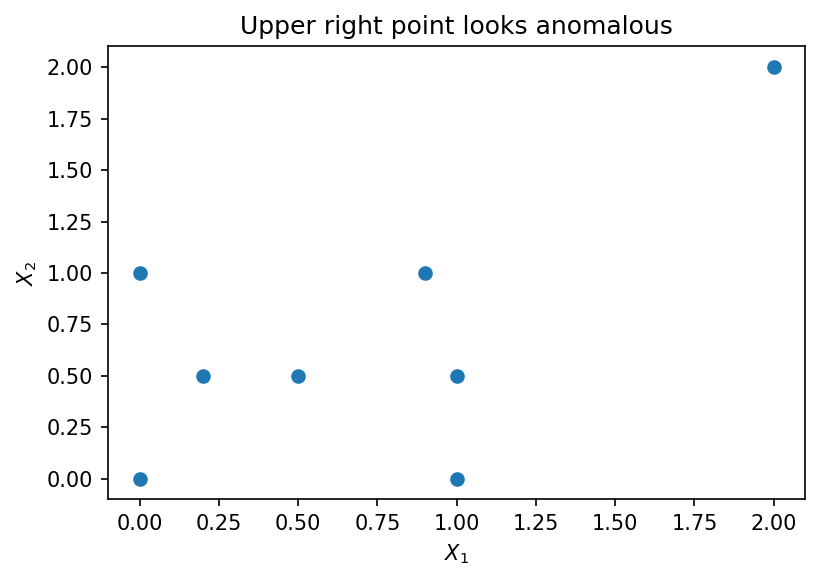

In [3]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

Let's create a function to visualize a query point and its neighbors more explicitly.

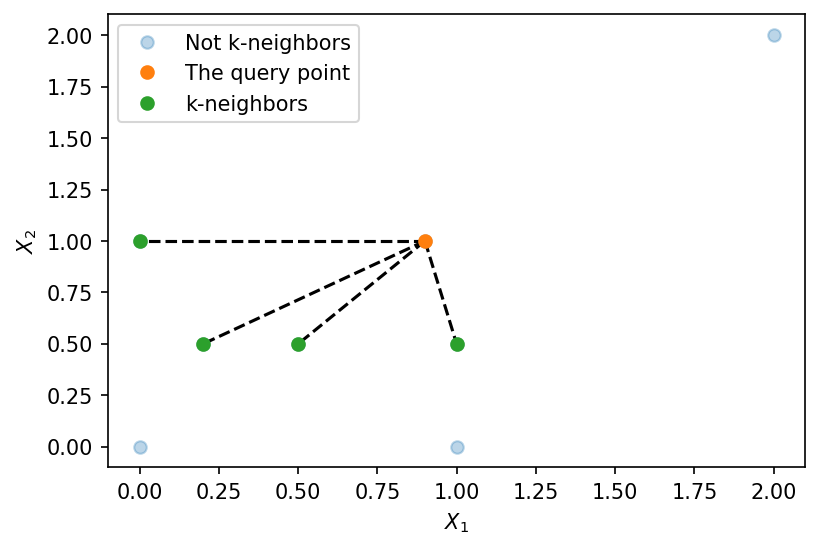

In [4]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    dist, index = nn.kneighbors()
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    
# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Here we can see the 4 points close to the query point (index of 0 in our data) are relatively close. Let's look at the anomalous point in the upper right (this point has an index of 7):

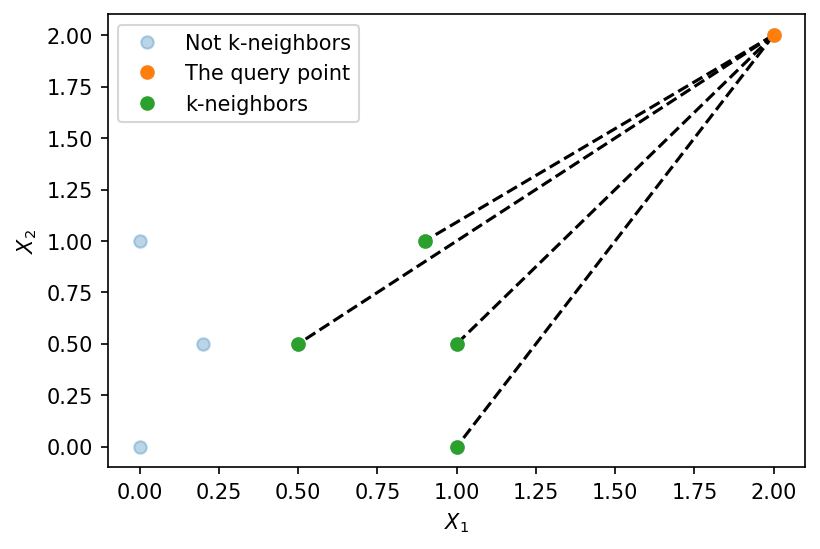

In [5]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

We can see in this case all of the 4-nearest neighbors to our point are far away, so it seems reasonably unambiguous to call this point an anomaly.

Let's add one more point next to the anomaly, and see how choosing "k" and the scoring function affects things.

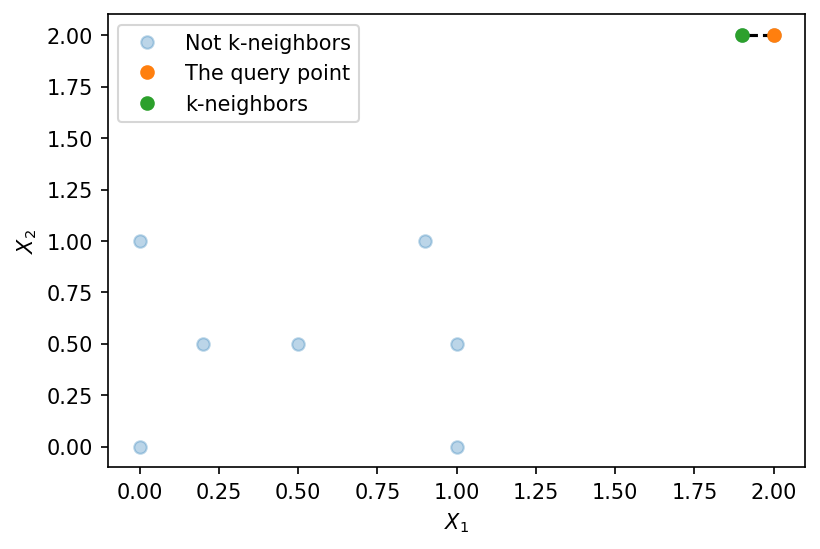

In [6]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

### Observation 1: dependence on $k$

The distance between point 7 and the new point is actually quite small—smaller than the distances between any pair of the points in the lower left. If $k=1$, the two points in the upper right would be the _last_ ones to classified as an anomaly (i.e. they would have the lowest score).

### Observation 2: how to weight distances?

Let's look at the same data set (i.e. with the additional point) but now look at $k=3$

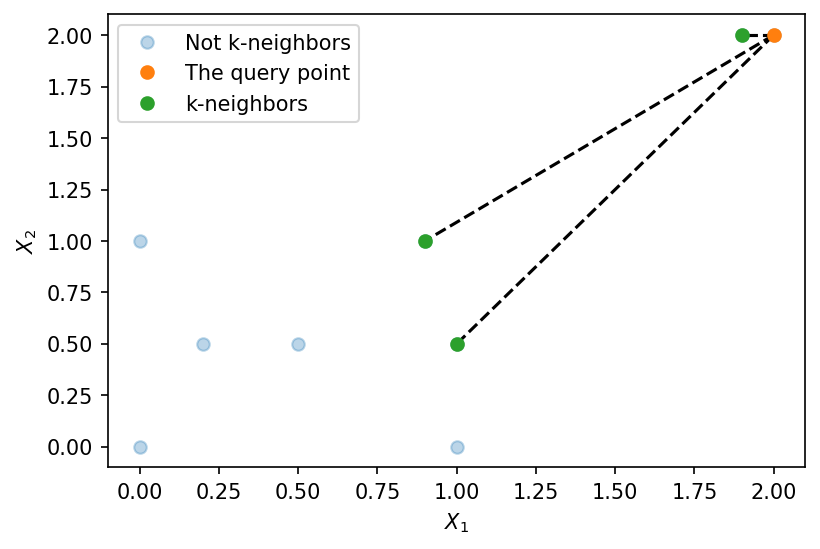

In [7]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

We see one of the 3 nearest neighbors is very close, but the other two are far away. We need some way of combining these 3 distances into a single score. The three commonly used methods are
1. Use the longest distance
2. Use the (arithmetic) mean distance
3. Use the harmonic mean.

We will implement the longest distance, and assign the arithmetic mean distance and harmonic mean distance as exercises.

### Using the longest distance

In [8]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1]
    return scores

# Test 
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

We can make the output a little easier to understand

In [9]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Now look at the anomalies with k=1

In [10]:

print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


**TAKEAWAY:** The number of neighbors $k$ used in kNN drastically changes the results. Usually requires some domain expertise to know the value of $k$ or range of values for $k$ to be used.

## kNN in reverse: outlier detection using in-degree (ODIN)


Another distance-based variation, called ODIN (outlier detection using in-degree), uses the same neighbors in a different way.  As discussed in the lesson, this algorithm asks the question, "who am I the nearest neighbor of?".  So, an example that serves as a NN of many others -- with many incoming links in the NN graph -- has a *low* anomaly score.  Examples with a small in-degree (= # of incoming links), are more likely to be anomalies. 

Here's an implementation of ODIN. Note that we convert the scores from the indegree value (low for an anomaly) to a zero-to-one scale where higher values are more of anomaly.

In [11]:
def do_odin_outlier_scores(obs, n_neighbors=3):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(obs)
    graph = nn.kneighbors_graph()
    indegree = graph.sum(axis=0)  # sparse matrix

    # smaller indegree means more of an anomaly  
    # simple conversion to [0,1] so larger score is more of anomaly
    scores = (indegree.max() - indegree) / indegree.max()
    return np.array(scores)[0]  # convert to array

Score and rank the points for the _X2_ dataset (two adjacent anomalies).

In [12]:
scores_odin= do_odin_outlier_scores(X2)

In [13]:
print_ranked_scores(X2, scores_odin)

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.8333
  2.  [0. 0.]		0.8333
  3.  [2. 2.]		0.8333
  4.  [1.9 2. ]		0.8333
  5.  [1. 0.]		0.6667
  6.  [0.9 1. ]		0.1667
  7.  [0.2 0.5]		0.1667
  8.  [1.  0.5]		0.1667
  9.  [0.5 0.5]		0.0000


The two anomalies (2, 2) and (1.9, 2) have large scores, but so do the points (0, 1) and (0, 1). Also, the result is different from we found with k-means results. As we discussed in the lecture, the method you use matters.

# Section 2: Cluster-Based Method (k-Means)

Clustering via k-means can be used as an anomaly detection method by:

  1. generating clusters, 
  2. finding the cluster of each example, 
  3. using the distance from the example to its cluster's center as a score
  
These pieces are available using `cluster.KMeans` which after fitting and predicting to get the clusters -- both where the clusters are and what cluster an example belongs to -- provides a `cluster_centers_` attribute.  Then we can use numpy's `numpy.linalg.norm` (often imported as `import numpy.linalg as nla`) to compute distances for us.

We will start by generating some data, then showing what the clusters are, and finally scoring the anomalies. 

**Data generation and view**

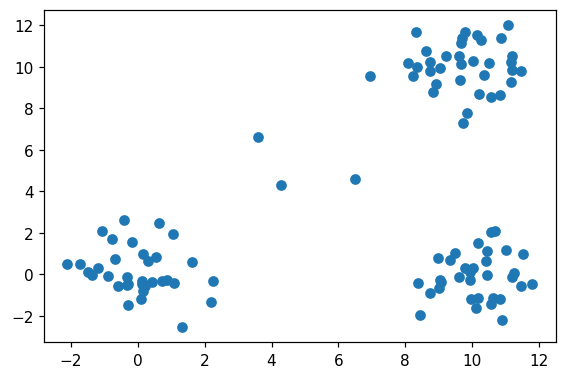

In [14]:
blobs_X, cluster_labels = sk_data.make_blobs(centers=[[0,0], [10,10], [10,0]])
anomalies, _ = sk_data.make_blobs(centers=[[5,5]], n_samples=5, cluster_std=3, random_state=42)

data = np.concatenate([blobs_X, anomalies])
cluster_labels = np.concatenate([cluster_labels, [-1]*len(anomalies)])

# Display the data before clustering
plt.figure(dpi=110)
plt.plot(data[:, 0], data[:, 1], 'o');

**Clustering and show cluster assignment**

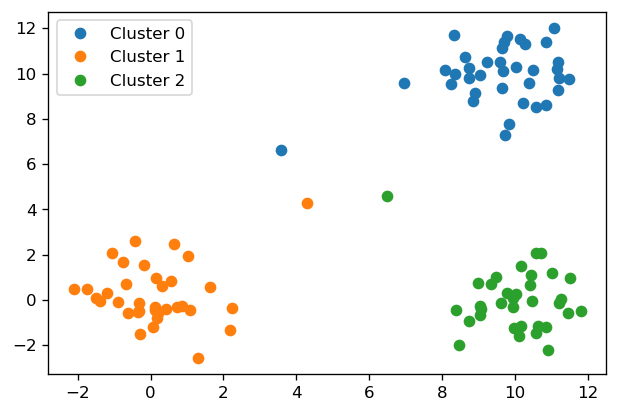

In [15]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

plt.figure(dpi=120)

for label in range(3):
    mask = (km.labels_ == label)
    plt.plot(data[mask, 0], data[mask, 1], 'o', label=f'Cluster {label}')
plt.legend();

You should run the clustering several times and note that the assignment of some points changes due to the different initial conditions (random choice of starting centroids).

**For each point, find the distance from the point to its centroid**

In [16]:
centers = km.cluster_centers_[km.labels_]
# show the centers for the first 10 points
centers[:10]

array([[ 0.1252,  0.267 ],
       [10.0161,  0.0305],
       [ 9.5653,  9.9388],
       [ 0.1252,  0.267 ],
       [10.0161,  0.0305],
       [ 0.1252,  0.267 ],
       [ 9.5653,  9.9388],
       [10.0161,  0.0305],
       [10.0161,  0.0305],
       [10.0161,  0.0305]])

In [17]:
#Get the distances to the centers as use these as the scores
score = np.linalg.norm(data - centers, axis=1)
score

array([0.6973, 1.2143, 2.1499, 1.539 , 1.4653, 0.8527, 1.9419, 1.6444,
       0.4406, 1.3313, 1.7279, 3.0659, 0.7326, 2.2718, 1.2669, 1.5382,
       2.4112, 1.3504, 0.9622, 0.9175, 0.8898, 0.5799, 1.6476, 1.8607,
       0.7265, 0.8275, 1.3896, 2.1762, 0.9136, 1.3269, 1.5099, 1.4485,
       1.6184, 1.2145, 2.6066, 1.88  , 1.1875, 1.0337, 1.6242, 2.4057,
       1.6921, 1.2032, 1.8241, 1.1158, 1.2385, 1.2529, 1.5902, 1.0122,
       0.725 , 1.3835, 1.5313, 1.7421, 1.1997, 2.2454, 1.0773, 0.6735,
       2.5484, 1.3047, 0.8419, 1.8326, 0.5243, 1.563 , 2.5405, 0.1993,
       0.5999, 0.7149, 1.7266, 2.1662, 1.0668, 2.0991, 1.1244, 1.2396,
       0.3916, 0.3449, 0.5765, 2.2089, 0.8836, 0.4392, 1.7832, 0.5894,
       0.0931, 1.524 , 2.1907, 1.1608, 1.6711, 1.4605, 1.1874, 0.8636,
       1.9163, 0.95  , 0.3517, 1.0193, 0.5846, 1.4705, 0.2531, 1.689 ,
       1.906 , 1.5924, 1.7374, 0.9234, 5.8012, 2.6482, 6.83  , 5.76  ,
       2.6421])

What are the 5 points with the highest scores? We will call those the anomalies

In [18]:

np.argsort(score)[::-1][:5]

array([102, 100, 103,  11, 101], dtype=int64)

Show these results in a plot that includes the cluster centers (labeled with an 'x')

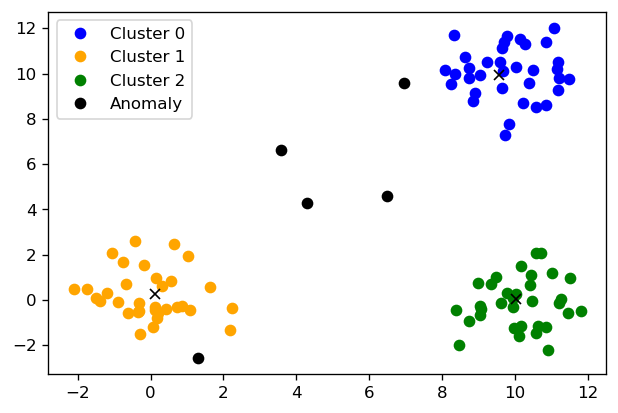

In [19]:

from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

anomaly_idx = np.argsort(score)[::-1][:5]
anomaly_mask = np.zeros(len(data))
anomaly_mask[anomaly_idx] = 1

plt.figure(dpi=120)
colors = ['blue', 'orange', 'green']

for label, color in enumerate(colors):
    mask = (km.labels_ == label) & (anomaly_mask == 0)
    plt.plot(data[mask, 0], data[mask, 1], marker='o', linestyle='none',
             color=color, label=f'Cluster {label}')
    plt.plot(*km.cluster_centers_[label], marker='x', color='k')

plt.plot(data[anomaly_idx, 0], data[anomaly_idx, 1], marker='o', linestyle='none',
         color='k', label='Anomaly')
plt.legend();

If you rerun the clustering enough times, you will find that the three central points are always labeled as anomalies. The other two anomalies vary depending on how the points are clustered.

**Note**: even bigger changes can be expected if the number of clusters is varied. Below we illustrate the effect of varying the number of clusters from 1 to 5.

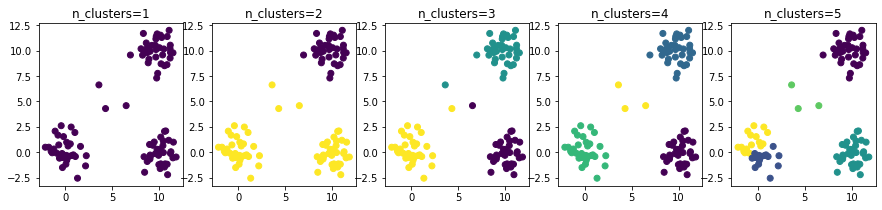

In [20]:
# Show clustering for user-specified number of clusters
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax, n_clusters in zip(axes, [1,2,3,4,5]):
    clust = KMeans(n_clusters=n_clusters)
    obs_to_clusters = clust.fit_predict(data) 
    ax.scatter(*data.T, c=obs_to_clusters)
    ax.set_title("n_clusters={}".format(n_clusters))

# Section 3: Density-Based Methods (Local Outlier Factor)

The local outlier factor (LOF) is `sklearn` has a version available for us to use. Note the the LOF returned by `sklearn` is the negative of the value we defined in the lecture.

Apply LOF to the collection of points ('X2') we created in section 1.

In [21]:
import sklearn.neighbors as neighbors
lof = neighbors.LocalOutlierFactor(n_neighbors=3, contamination='auto')
lof.fit(X2)
sk_lof = -lof.negative_outlier_factor_
print_ranked_scores(X2, sk_lof)

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8608
  2.  [1.9 2. ]		1.8293
  3.  [0.2 0.5]		1.2154
  4.  [1.  0.5]		1.2091
  5.  [0. 0.]		1.0333
  6.  [0. 1.]		1.0120
  7.  [1. 0.]		0.9554
  8.  [0.9 1. ]		0.8891
  9.  [0.5 0.5]		0.8272


See values both above and below 1. As discussed in the lecture, we expect the values significantly above 1 to be anomalies.

Compare with the kNN results from before. Note we use the same value of k (=3) for both algorithms.

In [22]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


The two anomalous points are both found either way, but there are differences between the results for the other points. 

For completeness, we provide below an explicit implementation of LOF that follows the outline given in the lecture. To check that our algorithm is reasonable, we compare the results for its anomaly score with those of the `sklearn` version for the cluster blobs ('data').

In [23]:
def lof_method(obs, n_neighbors=2):
    neigh = neighbors.NearestNeighbors(n_neighbors=2).fit(obs)
    
    #Return indices of and distances to the neighbors of each point
    topk_dist, my_kneigh = neigh.kneighbors()
    
    # Create list of distances of furthest (kth) neighbor 
    k_dist = topk_dist[:,-1]
 
    # Reachability distance: maximum of true distance between query neighbor and query point
    # and distance to kth nearest neighbor of query neighbor
    reach = np.maximum(topk_dist, k_dist[my_kneigh])
    
    # Local reacability density is reciprocal of average reachability distance
    lrd = 1.0 / np.mean(reach, axis=1)
    
    # Local outlier factor is given by
    # average local density of neighbors / local density of query point
    lrd_ratios = lrd[my_kneigh] / lrd[:, np.newaxis]
    lof = np.mean(lrd_ratios, axis=1)
    
    return lof

In [24]:
# Choose k=2
our_lof = lof_method(data, 2)
our_lof

array([0.9877, 0.9568, 2.3726, 0.972 , 0.8608, 0.9658, 1.2781, 0.9801,
       2.0323, 1.1109, 1.1083, 2.0135, 1.3611, 1.126 , 0.9104, 1.7849,
       2.2936, 1.3132, 1.0544, 1.0734, 1.0284, 0.9066, 0.911 , 1.0259,
       1.0455, 0.9028, 0.9114, 1.1478, 1.126 , 0.972 , 1.0305, 1.5695,
       1.1083, 1.0542, 2.4376, 1.2351, 1.0193, 1.0296, 1.0594, 1.1875,
       1.3266, 1.1206, 1.7392, 0.9104, 0.9753, 1.0577, 0.9501, 1.4513,
       1.1936, 1.0562, 0.8437, 1.2154, 0.9753, 1.2351, 1.3056, 1.058 ,
       1.3878, 1.1857, 0.9445, 0.9114, 0.9862, 1.0259, 2.6755, 0.9002,
       1.1978, 0.9877, 0.7013, 0.9737, 1.0934, 1.1478, 0.9658, 1.2376,
       1.0251, 1.2902, 1.3757, 1.0736, 1.0037, 1.2902, 1.1839, 1.0436,
       0.9943, 1.1402, 1.6814, 1.1424, 1.0578, 1.2493, 1.0058, 0.963 ,
       0.911 , 1.2184, 0.9943, 0.8272, 0.9847, 0.9501, 1.0115, 1.2138,
       1.8929, 1.0377, 1.2712, 1.7071, 1.1858, 2.5003, 0.9217, 0.9217,
       1.472 ])

In [25]:
lof2 = neighbors.LocalOutlierFactor(n_neighbors=2, contamination='auto')
lof2.fit(data)
sk_lof2 = -lof2.negative_outlier_factor_
print('Same as sklearn?', np.allclose(our_lof, sk_lof2))

Same as sklearn? True


### Exercise #1

This exercise refers to the distance-based methods (Section 1).

A. Create a function `do_nn_avg_scores(obs, n_neighbors=1)` that computes outlier scores using arithmetic mean distance from the point to each of the `n_neighbors` nearest neighbors as the score. 

B. Do the same thing as in part (A) to create `do_nn_harm_scores(obs, n_neighbors=1)`, where you use the harmonic mean instead of the mean. The harmonic mean of $n$ points is defined as

$$\text{harmonic}(X_1, X_2, \ldots, X_n) = \frac{n}{(1/x_1) + (1/x_2) + \ldots + (1/x_n)} = \frac{\left(\prod X_i\right)^{1/n}}{\bar{X}} = \frac{(X_1X_2\cdot X_n)^{1/n}}{\bar{X}}$$

   Note that `scipy.stats` contains a `hmean` function you can use.
  
Try each of these functions on our toy dataset, $X2$.

### Solution #1

In [26]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to cluster-based methods (k-means; Section 2).

A. Combine the code in the individual cells to create a function `do_cluster_outlier_scores(obs, n_clusters=3)` that computes outlier scores using the cluster method. Check that you find the same top five anomalies as before.

B. Combine the code in the individual cells to create a function `plot_clusters_and_outliers(obs, n_clusters=3, n_anomalies=5)` that generates a plot like the one above. Do you get the same results as before?

### Solution #2

In [27]:
# YOUR CODE HERE

### Exercise #3

This exercise refers to density-based methods (Local Outlier Factor; Section 3).


A. Create a function `do_lof_outlier_scores(obs, n_neighbors=3)` that computes outlier scores using the LOF method.  Recall that the values returned by sklearn's implementation are negatives of what we want.

B. Apply your function to our toy dataset `data` to get the top five anomalies.

C. How sensitive is the LOF method to `n_neighbors`?  Trying varying `n_neighbors` on the `data` dataset.

### Solution #3

In [28]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. How to make a kNN anomaly detector (distance based) 
2. How to make a k-means anomaly detector (cluster based) 
3. To use the Local Outlier Factor to classify anomalies 

Congratulations! This concludes the lesson.

In [29]:
print('end')

end
